In [ ]:
# Importing libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
# Reading the data set from drive

image_df = pd.read_csv('data/Age_Gender_Ethinicity_Data.csv')

We are trying to identify three targets:

1. Age - Rang from 1-116
2. Ethnicity - 0: White, 1: Black, 2: Asian, 3: Indian, 4: Other
3. Gender - 0: Male, 1: Female

In [ ]:
image_df.info()
image_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
image_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


### **Data Categorizing & Prepration**


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


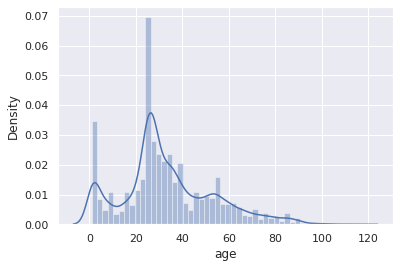

In [ ]:
# Age
sns.distplot(image_df['age'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


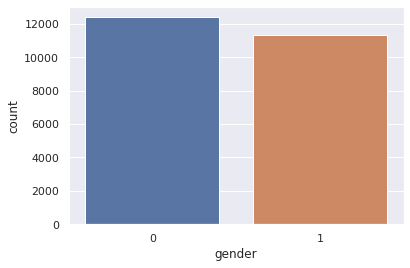

In [ ]:
# Gender
sns.countplot(image_df['gender'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


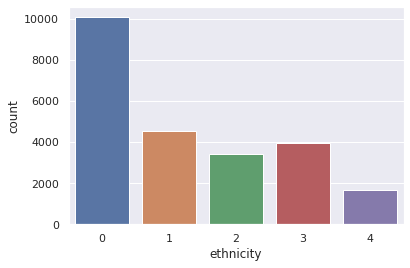

In [ ]:
# Ethnicity
sns.countplot(image_df['ethnicity'])

### **Data Pre Processing**

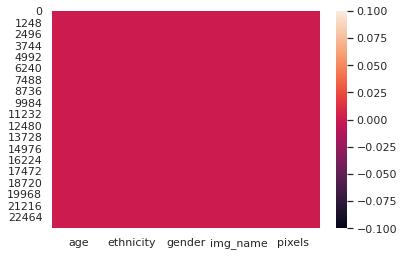

In [ ]:
image_df.isnull().sum()
sns.heatmap(image_df.isnull())

**Features Dependency** 

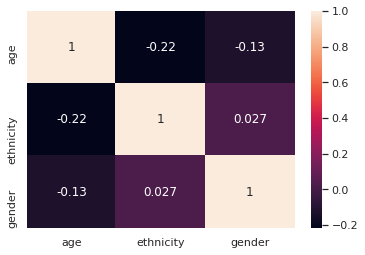

In [ ]:
sns.heatmap(image_df.corr(),annot = True)

The give images are in 'string' format. so we need to change into more readble format for images.


In [ ]:
# Total Number of images (enteries)

len(np.array(image_df['pixels'].to_list()))

23705

In [ ]:
# Number of pixels per image 

print(len(image_df['pixels'][0].split(' ')))

2304


In [ ]:
int(np.sqrt(2304))

48

In [ ]:
int(np.sqrt(len(image_df['pixels'][0].split(' '))))

48

In [ ]:
# Dimensions of the image
num_pixels = len(image_df['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
image_width = dimension
image_height = dimension

print("Width: {0}, Height: {1}".format(image_width, image_height))

Width: 48, Height: 48


In [ ]:
X = np.array(image_df['pixels'].to_list())


Variable 'image_name' might not helping for predictions, so lets drop it.

In [ ]:
# Input image classification

num_pixels = len(image_df['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
image_width = dimension
image_height = dimension


print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(image_width, image_height))

Pixels: 2304
Width: 48, Height: 48


**Ploting some images from the dataset**

In [ ]:
image_df['pixels'] = image_df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

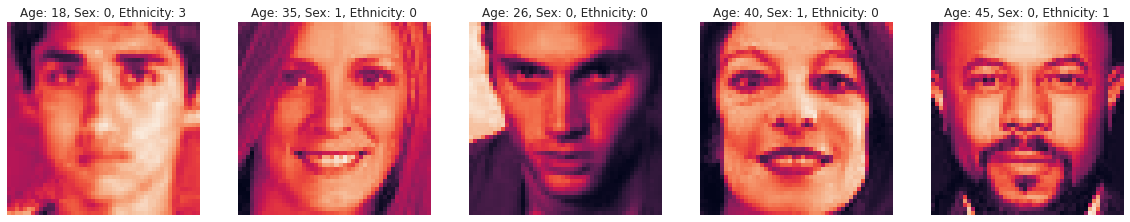

In [ ]:

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
  random_face = np.random.choice(len(image_df))

  age = image_df['age'][random_face]
  ethnicity = image_df['ethnicity'][random_face]
  gender = image_df['gender'][random_face]

  axes[i].set_title('Age: {0}, Sex: {1}, Ethnicity: {2}'.format(age, gender, ethnicity))
  axes[i].imshow(image_df['pixels'][random_face])
  axes[i].axis('off')

**Convert pixels values of the dataset into float type and normalize the dataset for using CNN (Convolutional Neural Network)**

In [ ]:
num_pixels = 2304
image_height = 48
image_width = 48

# Reshaping the image for CNN

X = np.array(image_df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)


# Normalizing the images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255


# setting some variable to execute the model

input_shape = X_reshaped.shape[1:]
n_epochs = 25
batch_size = 64

In [ ]:
image_df['img_name']

0        20161219203650636.jpg.chip.jpg
1        20161219222752047.jpg.chip.jpg
2        20161219222832191.jpg.chip.jpg
3        20161220144911423.jpg.chip.jpg
4        20161220144914327.jpg.chip.jpg
                      ...              
23700    20170120221920654.jpg.chip.jpg
23701    20170120134639935.jpg.chip.jpg
23702    20170110182418864.jpg.chip.jpg
23703    20170117195405372.jpg.chip.jpg
23704    20170110182052119.jpg.chip.jpg
Name: img_name, Length: 23705, dtype: object

As 'img_nmae' might not be used for analysis so we can dropp it

In [ ]:
image_df = image_df.drop('img_name', axis=1)

In [ ]:

image_df.head(1)

,age,ethnicity,gender,pixels
0,1,2,0,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13..."


### **Model for 'Age' prediction using CNN**

In [ ]:
# As we have defined 'X' as test dataset (pixels) now define the 'y' which is target, in three cases'age', 'gender' and 'ethnicity.

y_age = image_df['age'].values

# Train Test split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_age, test_size=0.2)

# Creating model 

# Batch size = 64
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

# number of layers = 128
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

# number of layers = 256
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

# number of layers = 512
age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

# Flattening the image

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

# Complining the model and finding accuracy
age_model.compile(optimizer='adam', loss='mse')
             

age_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0

In [ ]:
# Calbacks for age_model
# Calbacks is instrumental to use inorder to get a view on internal states and statistics of the model during training...
# Callbacks works to monitor the minimum value of loss value and see if in two consective attempts show minimum loss value then it stops computing

callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]


In [ ]:
# Now fit the model

history_age_mod = age_model.fit(X_train, y_train, 
                                epochs = n_epochs, 
                                batch_size= batch_size, 
                                callbacks=callbacks, 
                                validation_data = (X_test, y_test))

Epoch 1/25
297/297 [==============================] - 15s 22ms/step - loss: 418.4377 - val_loss: 1884.6484
Epoch 2/25
297/297 [==============================] - 6s 20ms/step - loss: 141.0688 - val_loss: 1318.1086
Epoch 3/25
297/297 [==============================] - 6s 21ms/step - loss: 125.9695 - val_loss: 102.5001
Epoch 4/25
297/297 [==============================] - 6s 21ms/step - loss: 103.4641 - val_loss: 138.0778
Epoch 5/25
297/297 [==============================] - 6s 21ms/step - loss: 103.3887 - val_loss: 150.0091

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/25
297/297 [==============================] - 6s 21ms/step - loss: 88.9510 - val_loss: 74.4863
Epoch 7/25
297/297 [==============================] - 6s 21ms/step - loss: 78.9860 - val_loss: 96.4863
Epoch 8/25
297/297 [==============================] - 6s 21ms/step - loss: 74.7311 - val_loss: 72.1303
Epoch 9/25
297/297 [==============================] - 6s 21ms/step - loss: 73.739

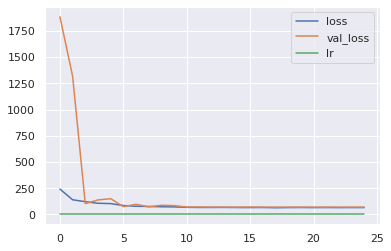

In [ ]:
pd.DataFrame(history_age_mod.history).plot()

In [ ]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)


149/149 [==============================] - 1s 4ms/step - loss: 69.2965


In [ ]:
# Make predictions 
y_pred = age_model.predict(X_test)

In [ ]:
# Mean absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.8142996421345075


**Concluding** ...As Loss score shows 65.097 and squre root of it 

 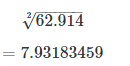

 shows 7.9318. Which reflects that in age model the values can be off by ~ 7 years.

 However the predicted mean absolute error is in the range of 5.57.

### **Model for 'Gender' prediction using CNN**

In [ ]:
# As we have defined 'X' as test dataset (pixels) now define the 'y' which is target, in three cases'age', 'gender' and 'ethnicity.

y_gender = image_df['gender'].values

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_gender, test_size=0.2, random_state = 42)

# Creating model 

# number of layers = 64
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

# number of layers = 128
gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.3))
gender_model.add(BatchNormalization())

# number of layers = 256
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.3))
gender_model.add(BatchNormalization())

# Flattening the image

gender_model.add(Flatten())
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))
gender_model.add(Dense(1))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

# Complining the model and finding accuracy
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 9, 128)        

In [ ]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
history_gender_mod = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 6s 18ms/step - loss: 0.5397 - accuracy: 0.7324 - val_loss: 1.2520 - val_accuracy: 0.5206
Epoch 2/25
297/297 [==============================] - 5s 17ms/step - loss: 0.3383 - accuracy: 0.8473 - val_loss: 0.4226 - val_accuracy: 0.7956
Epoch 3/25
297/297 [==============================] - 5s 17ms/step - loss: 0.2892 - accuracy: 0.8712 - val_loss: 0.3218 - val_accuracy: 0.8543
Epoch 4/25
297/297 [==============================] - 5s 17ms/step - loss: 0.2620 - accuracy: 0.8846 - val_loss: 0.2850 - val_accuracy: 0.8766
Epoch 5/25
297/297 [==============================] - 5s 17ms/step - loss: 0.2502 - accuracy: 0.8895 - val_loss: 0.2590 - val_accuracy: 0.8817
Epoch 6/25
297/297 [==============================] - 5s 17ms/step - loss: 0.2311 - accuracy: 0.9012 - val_loss: 0.2538 - val_accuracy: 0.8903
Epoch 7/25
297/297 [==============================] - 5s 17ms/step - loss: 0.2098 - accuracy: 0.9089 - val_loss: 0.2687 - val_accuracy: 0.8829

In [ ]:
# Metrics
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.2545 - accuracy: 0.9040
Accuracy for test set: 0.9040287137031555


In [ ]:
gender_acc = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(gender_acc[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.2545 - accuracy: 0.9040
Accuracy for test set: 0.9040287137031555


In [ ]:
y_pred = gender_model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2468
           1       0.90      0.90      0.90      2273

    accuracy                           0.90      4741
   macro avg       0.90      0.90      0.90      4741
weighted avg       0.90      0.90      0.90      4741



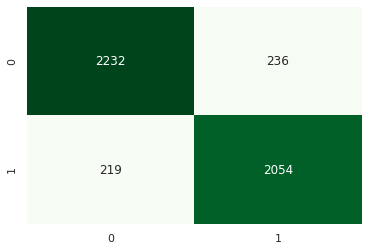

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

**Concluding** .. Hence 'Gender Model' has 'binary selection' so the accuracy metrics has been calculated which shows the accuracy range of ~ 90%, indeed very good.
However From confusion metrics we see higher number in FN (221) and in TN (253), which might be due the kids as its sometimes difficult to predict them. 

Lets examine the model so far..

In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0])

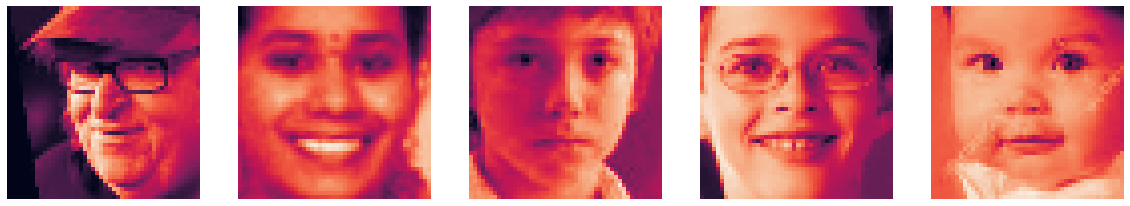

In [ ]:
# Now prediting mode - predicting 'False Positive'
# Model predicting female, actually it's male

X_fp = X_test[(y_pred == 1) & (y_test == 0)] 

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fp))
    
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

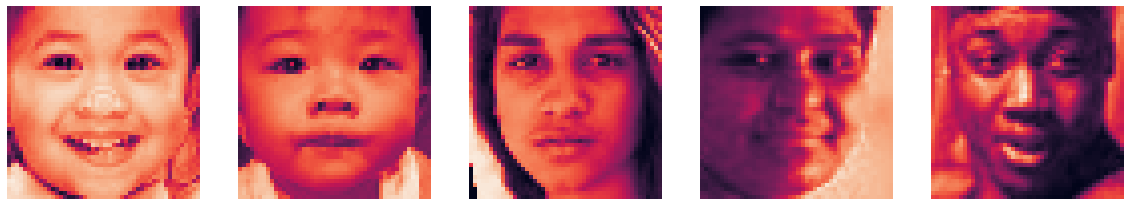

In [ ]:
# Model predict is male, but actually it's female

X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

The big portion of these predictions showing false is might be due to childern pictures. More over ethnicity model needs to be defined as well..

### **Model for 'Ethnicity' prediction using CNN**

In [ ]:
y_ethnicity = image_df['ethnicity'].values

# Multiclass problem, transfer to on_hot_encoding
# Ethnicity - 0: White, 1: Black, 2: Asian, 3: Indian, 4: Other

y_ethnicity = to_categorical(y_ethnicity, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_ethnicity, test_size=0.2, random_state=42)

In [ ]:
ethnicity_model = Sequential()

# Defining the model

ethnicity_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(Dropout(0.5))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Flatten())
ethnicity_model.add(Dense(128, activation='relu'))
ethnicity_model.add(Dropout(0.5))
ethnicity_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

ethnicity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

ethnicity_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
# Callbacks for ethnicity model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
ethnicity_history = ethnicity_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 4s 13ms/step - loss: 1.4730 - accuracy: 0.4904 - val_loss: 3.6361 - val_accuracy: 0.4318
Epoch 2/25
297/297 [==============================] - 3s 12ms/step - loss: 0.9191 - accuracy: 0.6719 - val_loss: 0.9273 - val_accuracy: 0.6214
Epoch 3/25
297/297 [==============================] - 4s 12ms/step - loss: 0.8252 - accuracy: 0.7153 - val_loss: 0.7576 - val_accuracy: 0.7245
Epoch 4/25
297/297 [==============================] - 4s 12ms/step - loss: 0.7469 - accuracy: 0.7492 - val_loss: 0.8258 - val_accuracy: 0.7125
Epoch 5/25
297/297 [==============================] - 4s 12ms/step - loss: 0.6895 - accuracy: 0.7629 - val_loss: 0.7936 - val_accuracy: 0.6880

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/25
297/297 [==============================] - 3s 12ms/step - loss: 0.6071 - accuracy: 0.7914 - val_loss: 0.5879 - val_accuracy: 0.7916
Epoch 7/25
297/297 [==============================] - 3s 12m

In [ ]:
# now lets see the validation score

valid_score = ethnicity_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 3ms/step - loss: 0.5605 - accuracy: 0.8078


In [ ]:
ethnicity_acc = ethnicity_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(ethnicity_acc[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.5605 - accuracy: 0.8078
Accuracy for test set: 0.8078464269638062


In [ ]:
y_pred = ethnicity_model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# Convert to 0 to 4 scale 
y_test_labels = [np.argmax(i) for i in y_test]

In [ ]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2047
           1       0.85      0.85      0.85       904
           2       0.85      0.86      0.86       657
           3       0.72      0.79      0.75       804
           4       0.43      0.12      0.18       329

    accuracy                           0.81      4741
   macro avg       0.73      0.70      0.70      4741
weighted avg       0.79      0.81      0.79      4741



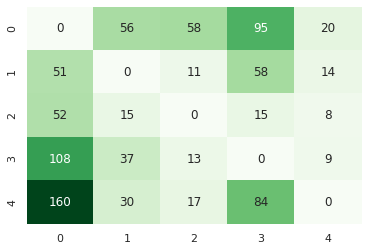

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');

**concluding** .. Ethnicity model gives us an accuracy range of ~ 81 %. Let's pull some randome faces and see model performence.

## **Model Performence** - **Selecting Random Faces** 

In [ ]:
# Final checking / verifying model

def face_prediction(image):
  x = image.reshape(1, 48, 48, 1)
  x = x / 255
    
  age_predict = int(age_model.predict(x))
  gender_predict = int(gender_model.predict_classes(x))
  ethnicity_predict = int(ethnicity_model.predict_classes(x))
    
  gender = {0: 'Male', 1: 'Female'}
  ethnicity_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    
  plt.imshow(image)
  plt.title('{0}, {1}, {2}'.format(age_predict, gender[gender_predict], ethnicity_group[ethnicity_predict]))
  plt.axis('off')


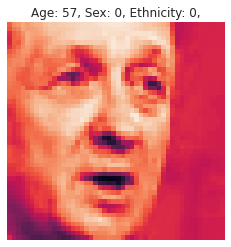

In [ ]:
# Final results

random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


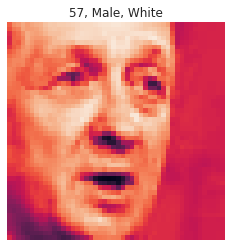

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

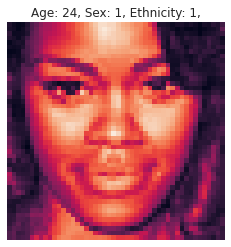

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


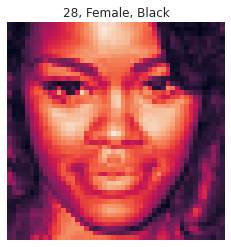

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

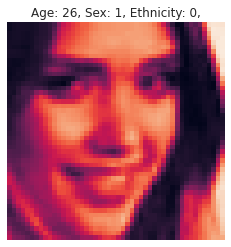

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


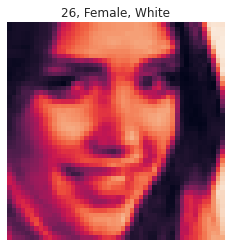

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

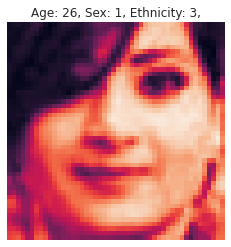

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


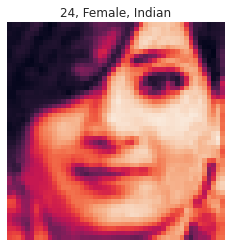

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

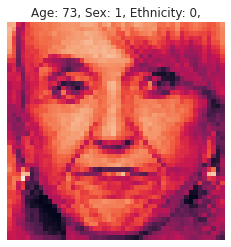

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


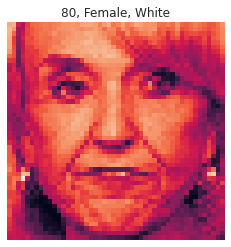

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

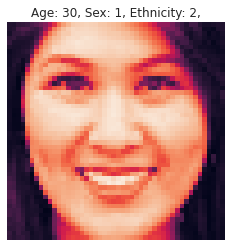

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


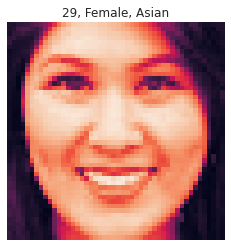

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])

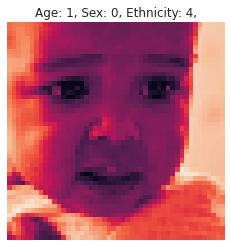

In [ ]:
random_face = np.random.choice(len(image_df))

age = image_df['age'][random_face]
ethnicity = image_df['ethnicity'][random_face]
gender = image_df['gender'][random_face]

plt.imshow(image_df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


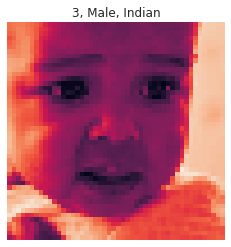

In [ ]:
# Model prediction 
face_prediction(image_df['pixels'][random_face])



```
# This is formatted as code
```

## **Conclusion** - **Evaluating Models**

After random selection of faces from the data base we conclude that there is minimum or no error in predicting the 'Gender' and 'Ethnicity' of each face randomly selected from database consisting more than ~ 23700 images . However in some case the 'Age Model' varies in age prediction but that is still in the range of expected loss/ error of ~ 7.13 years.